# Raster Data Processes

The goal of this notebook is to:  
1. Open and reproject raster data
> a. Save new file as reprojected <br>
> b. Clip and plot for the study area <br>
2. Subproducts of DEM.
> a. Slope   
> b. Roughness  
> c. Aspect  
3. Data Characterization  

Also, visually represent the compiled data in our pandas dataframe. <br>  

-- Please note that this notebook uses ChatGPT inspired code for some processes <br>

### Miscelaneous preparation

In [ ]:
# Connect to google drive data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio

In [1]:
# Import libraries - vector data
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
import re
from shapely.wkt import dumps
import numpy as np

# Import libraries - Raster
import rasterio as rio
import rasterio.plot
import rasterio.mask
from rasterio.warp import calculate_default_transform
from rasterio.warp import reproject, Resampling
import os

In [2]:
# Get study area and bounds

# Path to the shapefile containing the landslide inventory
main_path = '/content/drive/MyDrive/MLGeo23_Landslide_FinalProject/data'

#open study area
study_area = gpd.read_file(main_path + '/study_area/king_county_sf.shp')

# Define Projection -- using stud area projection as reference:
proj = study_area.crs
print(proj)

PROJCS["NAD83(HARN) / Washington South (ftUS)",GEOGCS["NAD83(HARN)",DATUM["NAD83_High_Accuracy_Reference_Network",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6152"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",45.3333333333333],PARAMETER["central_meridian",-120.5],PARAMETER["standard_parallel_1",45.8333333333333],PARAMETER["standard_parallel_2",47.3333333333333],PARAMETER["false_easting",1640416.66666667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [4]:
study_area.to_file(main_path + 'study_area.gpkg')

## 1.  Open and Reproject Raster Data


Reprojection raster function <br>

In [ ]:
# raster reprojection function
def rio_reproj_write(src, proj_fn, dst_crs, driver='HFA'):
    #Check to see if output filename already exists
    if os.path.exists(proj_fn):
        print("File exists: ", proj_fn)
    else:
        #Get the required transformation and output width and height
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        #Create a copy of input metadata, then update with output values
        kwargs = src.meta.copy()
        print("Source metadata:\n", kwargs)
        kwargs.update({'crs':dst_crs,'transform':transform,'width':width,'height':height})
        kwargs['driver'] = driver
        #Set output creation options
        kwargs['compress'] = 'LZW'
        kwargs['tiled'] = True
        kwargs['BIGTIFF'] = 'IF_SAFER'
        print("Destination metadata:\n", kwargs)

        #Open the destination dataset in write mode
        with rio.open(proj_fn, 'w', **kwargs) as dst:
            print("Writing: ", proj_fn)
            #Loop through each input band
            for i in range(1, src.count + 1):
                #Reproject!
                reproject(source=rio.band(src, i), destination=rio.band(dst, i), src_transform=src.transform,\
                          src_crs=src.crs, dst_transform=transform, dst_crs=dst_crs, resampling=Resampling.cubic)
            print("Complete")

Slope

In [ ]:
''' Reprojection - Run only Once '''

# Opening the raster data with rasterio
raster_path = main_path + '/slope_wa/wa_slope.tif' # write path of raster data - DEM
with rio.open(raster_path) as src:
    print(src.profile)

# Call reprojection function and save
src = rio.open(raster_path)
proj_fn = os.path.splitext(raster_path)[0]+'_reproj.tif' # name of reprojected data - DEM_reproj
rio_reproj_write(src, proj_fn, proj)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 27759, 'height': 41750, 'count': 1, 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(26.98051457905543, 0.0, -2294525.3688,
       0.0, -26.98051457964071, 1678466.4048), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
File exists:  /content/drive/MyDrive/MLGeo23_Landslide_FinalProject/data/slop

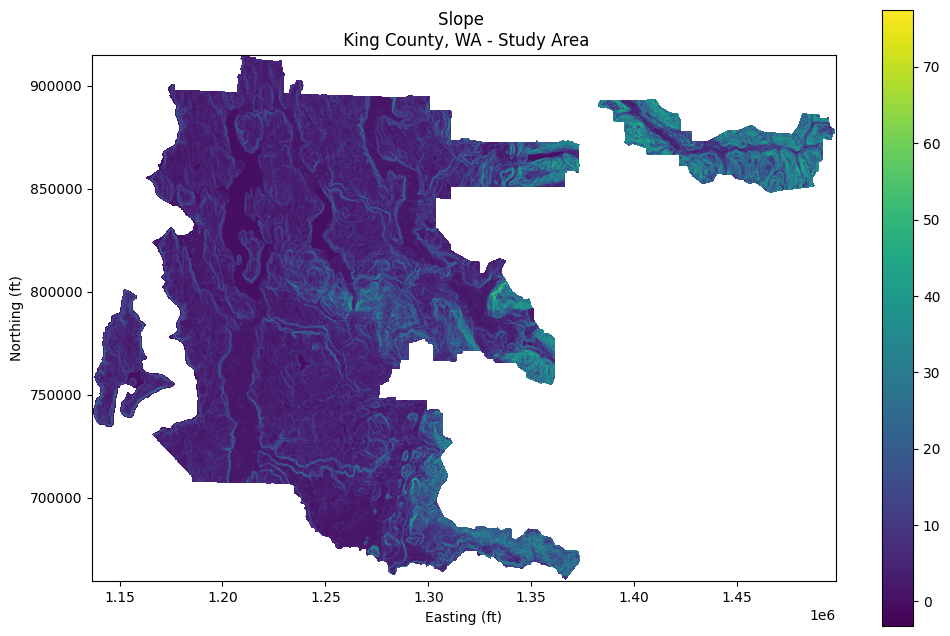

In [ ]:
# open raster and clip
raster_path = main_path + '/slope_wa/wa_slope_reproj.tif' # change the path
src = rio.open(raster_path)

# clip for KC study area
geom = study_area.geometry
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
ma, ma_transform = rio.mask.mask(src, geom, **rio_mask_kwargs)

#Get clipped extent in PROJ coordaintes for plotting
ma_extent = rio.plot.plotting_extent(ma, ma_transform)

# Sanity check
f, ax = plt.subplots(figsize=(12,8))
map = ax.imshow(ma, extent=ma_extent, cmap = 'viridis')
plt.title('Slope \n King County, WA - Study Area')
plt.xlabel('Easting (ft)')
plt.ylabel('Northing (ft)')
f.colorbar(map, ax=ax);

In [ ]:
# Geometry area and centroid // Adding columns
gdf = gpd.read_file(main_path + '/inventory/inventory_gdf.gpkg')
gdf['centroid'] = gdf.geometry.centroid
centroid = gdf['centroid']

#define buffer
buff_dist = src.res[0]*3

# create new geodataframe
centroid_buff = centroid.buffer(buff_dist)

centroid_buff_gdf = gpd.GeoDataFrame(centroid.copy(), geometry=centroid_buff)

In [ ]:
!pip install rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
import rasterstats
# Define relevant stats for our sampling
stats = ['min', 'max', 'mean', 'std']

# rasterstats
gdf_zonal_stats = rasterstats.zonal_stats(centroid_buff_gdf, ma, affine = ma_transform, nodata=src.nodata, stats=stats)

# creating a DataFrame to store values in the original inventory data
zonal_stats_df = pd.DataFrame(gdf_zonal_stats, index = centroid_buff_gdf.index)

In [ ]:
# join two dataframes
csv = pd.read_csv(main_path + '/inventory_with_elev_rough.csv')
gdf_concat = pd.concat([csv, zonal_stats_df], axis=1)
# sanity check
gdf_concat.head(2)

,Unnamed: 0,OBJECTID,soruce_length,source_area,landslide_ID,deposit_area,CONFIDENCE,MATERIAL,SLOPE_DEG,HS_HEIGHT,...,mean_elev,std_elev,min_rough,max_rough,mean_rough,std_rough,min,max,mean,std
0,0,1,3851.588931,147260.070502,5600,531934.562792,moderate,Earth or debris,31,72,...,64.464286,11.004811,3.244220,39.711239,18.773749,8.939351,2.742452,32.380558,15.358492,7.426611
1,1,2,478.577643,7375.893616,5601,13973.308516,low,Earth or debris,31,40,...,46.607143,14.056872,17.112118,32.824306,24.181767,3.681896,14.538154,24.222824,18.963466,2.223287
2,2,3,621.878585,9097.112403,5602,25699.961862,low,Earth or debris,28,28,...,64.413793,11.366973,5.909607,27.995768,18.422395,6.574039,3.696535,22.295137,14.502633,5.365441
3,3,4,1187.857110,20648.173693,5603,94054.007176,low,Earth or debris,32,45,...,66.142857,11.624218,7.192145,37.364319,21.286560,8.332988,5.329493,27.280369,15.797822,5.754156
4,4,5,1866.133373,35616.221508,5604,90517.371084,moderate,Earth or debris,32,33,...,62.370370,9.047808,3.911461,37.364319,18.165191,8.389121,2.155986,25.588272,13.185511,6.302846


In [ ]:
# changing names for better practices:
gdf_concat = gdf_concat.rename(columns={'min':'min_slope', 'max':'max_slope', 'mean':'mean_slope', 'std':'std_slope'})

# last sanity check of the dataframe:
gdf_concat.head(2)

gdf_concat.to_csv(main_path + '/inventory_with_elev_rough_slope.csv')

,Unnamed: 0,OBJECTID,soruce_length,source_area,landslide_ID,deposit_area,CONFIDENCE,MATERIAL,SLOPE_DEG,HS_HEIGHT,...,mean_elev,std_elev,min_rough,max_rough,mean_rough,std_rough,min_slope,max_slope,mean_slope,std_slope
0,0,1,3851.588931,147260.070502,5600,531934.562792,moderate,Earth or debris,31,72,...,64.464286,11.004811,3.244220,39.711239,18.773749,8.939351,2.742452,32.380558,15.358492,7.426611
1,1,2,478.577643,7375.893616,5601,13973.308516,low,Earth or debris,31,40,...,46.607143,14.056872,17.112118,32.824306,24.181767,3.681896,14.538154,24.222824,18.963466,2.223287


In [ ]:
gdf_concat.to_csv(main_path + '/inventory_with_elev_rough_slope.csv')

a. Digital Elevation Model (DEM):

In [ ]:
''' Reprojection - Run only Once '''

# Opening the raster data with rasterio
raster_path = main_path + '/elevation/30m_wa_DEM.tif' # write path of raster data - DEM
with rio.open(raster_path) as src:
    print(src.profile)

# Call reprojection function and save
src = rio.open(raster_path)
proj_fn = os.path.splitext(raster_path)[0]+'_reproj.tif' # name of reprojected data - DEM_reproj
rio_reproj_write(src, proj_fn, proj)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 27759, 'height': 41750, 'count': 1, 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(26.98051457905543, 0.0, -2294525.3688,
       0.0, -26.98051457964071, 1678466.4048), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
File exists:  /content/drive/MyDrive/MLGeo23_Landslide_FinalProject/data/elevatio

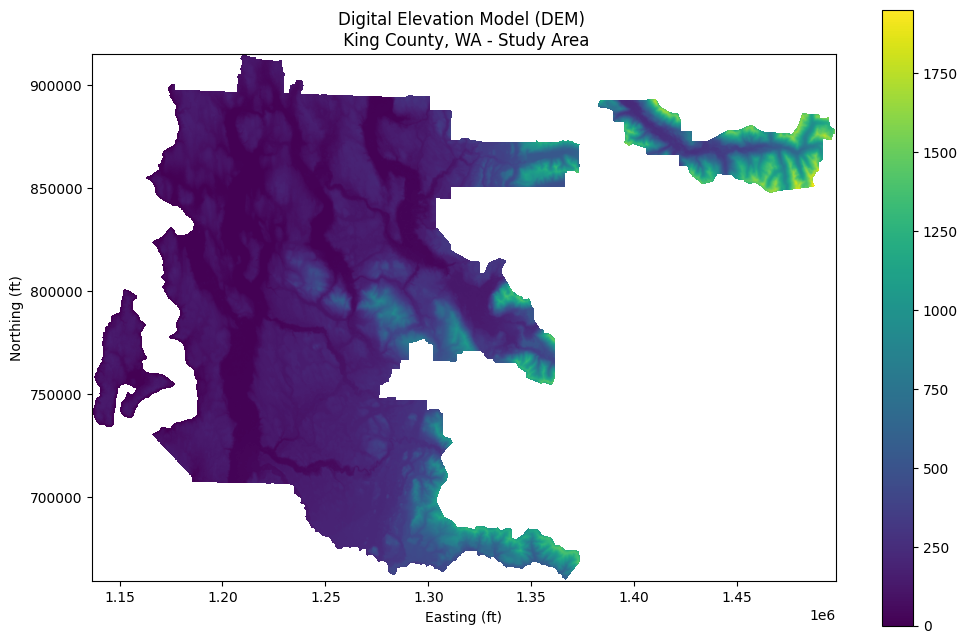

In [ ]:
''' Clip and quick plot '''

# Open repjected DEM
raster_reproj = rio.open(main_path + '/elevation/30m_wa_DEM_reproj.tif')

# define geometry of reference
geom = study_area.geometry

# Getting extent of masked raster array
ls_extent = rio.plot.plotting_extent(raster_reproj)

# clip for KC study area
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
ma, ma_transform = rio.mask.mask(raster_reproj, geom, **rio_mask_kwargs)

#Get clipped extent in PROJ coordaintes for plotting
ma_extent = rio.plot.plotting_extent(ma, ma_transform)

# Sanity check using or_ma
f, ax = plt.subplots(figsize=(12,8))
map = ax.imshow(ma, extent=ma_extent, cmap = 'viridis')
plt.title('Digital Elevation Model (DEM) \n King County, WA - Study Area')
plt.xlabel('Easting (ft)')
plt.ylabel('Northing (ft)')
f.colorbar(map, ax=ax);

In [ ]:
# Open the raster DEM file
raster_reproj = rio.open(main_path + '/elevation/30m_wa_DEM_reproj.tif')

# Get transformation parameters
transform = raster_reproj.transform

# Get raster values
raster_values = raster_reproj.read(1)  # Replace '1' with the band index if you have a multi-band raster

# Create a function to convert pixel coordinates to geographic coordinates
def pixel_to_coords(x, y):
    lon = transform * (x, y)
    return lon

# Example coordinates (replace with your x and y coordinates)
x_coordinate = 100  # Example x-coordinate
y_coordinate = 200  # Example y-coordinate

# Convert pixel coordinates to geographic coordinates
lon, lat = pixel_to_coords(x_coordinate, y_coordinate)

# Retrieve elevation value for the given coordinates
elevation = raster_values[y_coordinate, x_coordinate]  # Access raster data using y, x index

print(f"Latitude: {lat}, Longitude: {lon}, Elevation: {elevation}")

Latitude: 2065533.7161286892, Longitude: -51336.560160761495, Elevation: 0


b. Precipitation Data:

In [ ]:
''' Reprojection - Run only Once '''

# Opening the raster data with rasterio

months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
num = ['01','02','03','04','05','06','07','08','09','10','11','12']
i = 0

raster_path = main_path + '/precipiation/30m_wa_DEM.tif' # write path of raster data
with rio.open(raster_path) as src:
    print(src.profile)

# Call reprojection function and save
src = rio.open(raster_path)
proj_fn = os.path.splitext(raster_path)[0]+'_reproj.tif' # name of reprojected data
rio_reproj_write(src, proj_fn, proj)

RasterioIOError: ignored

In [ ]:
for m in months:
    fp = os.path.join('precip','wc2.1_30s_prec_{}.tif'.format(num[i]))
    xds = rioxarray.open_rasterio(
        fp,
        masked=True)
    clipped = xds.rio.clip(seattle_polygon)
    clipped.rio.to_raster('{}_prec.tif'.format(m))
    xds.close()

    rds = rioxarray.open_rasterio('{}_prec.tif'.format(m))
    rds = rds.squeeze().drop("spatial_ref").drop("band")
    # rds = rds.rename({'x':'lon','y':'lat'})
    rds.name = "data"
    df = rds.to_dataframe().reset_index()
    df[df.data>=0.0].to_csv("{}.csv".format(m), index=False)
    i = i+1

c. Water Table Data:

In [ ]:
''' WATER TABLE DATA '''
# Opening the raster data with rasterio
raster_path = main_path + '/wtd_north_america_CF.tif' # write path of raster data
with rio.open(raster_path) as src:
    print(src.profile)

# Call reprojection function and save
src = rio.open(raster_path)
proj_fn = os.path.splitext(raster_path)[0]+'_reproj.tif' # name of reprojected data
rio_reproj_write(src, proj_fn, proj)

## 2. Sub-products of DEM.
> a. Slope  
> b. Roughness  
> c. Aspect  

In [ ]:
### Slope:
''' Slope Reprojection - Run only Once '''

# Opening the raster data with rasterio
raster_path = main_path + '/slope_wa/wa_slope.tif' # write path of raster data - DEM
with rio.open(raster_path) as src:
    print(src.profile)

# Call reprojection function and save
src = rio.open(raster_path)
proj_fn = os.path.splitext(raster_path)[0]+'_reproj.tif' # name of reprojected data - DEM_reproj
rio_reproj_write(src, proj_fn, proj)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 27759, 'height': 41750, 'count': 1, 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(26.98051457905543, 0.0, -2294525.3688,
       0.0, -26.98051457964071, 1678466.4048), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


Source metadata:
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 27759, 'height': 41750, 'count': 1, 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(26.98051457905543, 0.0, -2294525.3688,
       0.0, -26.98051457964071, 1678466.4048)}
Destination metadata:
 {'driver': 'HFA', 'dtype': 'float32', 'nodata': -9999.0, 'width': 37452, 'height': 47583, '

In [ ]:
### Roughness:
''' Roughness Reprojection - Run only Once '''

# Opening the raster data with rasterio
raster_path = main_path + '/roughness_wa/wa_roughness.tif' # write path of raster data - DEM
with rio.open(raster_path) as src:
    print(src.profile)

# Call reprojection function and save
src = rio.open(raster_path)
proj_fn = os.path.splitext(raster_path)[0]+'_reproj.tif' # name of reprojected data - DEM_reproj
rio_reproj_write(src, proj_fn, proj)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 27759, 'height': 41750, 'count': 1, 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(26.98051457905543, 0.0, -2294525.3688,
       0.0, -26.98051457964071, 1678466.4048), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


Source metadata:
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 27759, 'height': 41750, 'count': 1, 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(26.98051457905543, 0.0, -2294525.3688,
       0.0, -26.98051457964071, 1678466.4048)}
Destination metadata:
 {'driver': 'HFA', 'dtype': 'float32', 'nodata': -9999.0, 'width': 37452, 'height': 47583, '

In [ ]:
### Aspect:
''' Aspect Reprojection - Run only Once '''

# Opening the raster data with rasterio
raster_path = main_path + '/aspect/wa_aspect.tif' # write path of raster data - DEM
with rio.open(raster_path) as src:
    print(src.profile)

# Call reprojection function and save
src = rio.open(raster_path)
proj_fn = os.path.splitext(raster_path)[0]+'_reproj.tif' # name of reprojected data - DEM_reproj
rio_reproj_write(src, proj_fn, proj)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 27759, 'height': 41750, 'count': 1, 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(26.98051457905543, 0.0, -2294525.3688,
       0.0, -26.98051457964071, 1678466.4048), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


Source metadata:
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 27759, 'height': 41750, 'count': 1, 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(26.98051457905543, 0.0, -2294525.3688,
       0.0, -26.98051457964071, 1678466.4048)}
Destination metadata:
 {'driver': 'HFA', 'dtype': 'float32', 'nodata': -9999.0, 'width': 37452, 'height': 47583, '

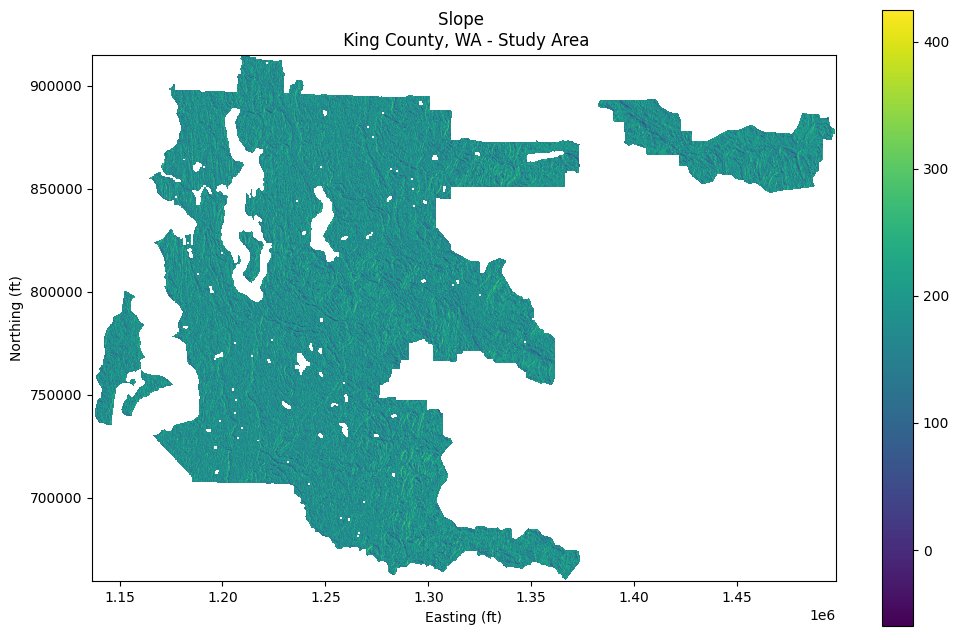

In [ ]:
# open raster and clip
raster_path = main_path + '/aspect/wa_aspect_reproj.tif' # change the path
src = rio.open(raster_path)

# clip for KC study area
geom = study_area.geometry
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
ma, ma_transform = rio.mask.mask(src, geom, **rio_mask_kwargs)

#Get clipped extent in PROJ coordaintes for plotting
ma_extent = rio.plot.plotting_extent(ma, ma_transform)

# Sanity check
f, ax = plt.subplots(figsize=(12,8))
map = ax.imshow(ma, extent=ma_extent, cmap = 'viridis')
plt.title('Slope \n King County, WA - Study Area')
plt.xlabel('Easting (ft)')
plt.ylabel('Northing (ft)')
f.colorbar(map, ax=ax);

In [ ]:
import rasterstats
# Define relevant stats for our sampling
stats = ['min', 'max', 'mean', 'std']

# rasterstats
gdf_zonal_stats = rasterstats.zonal_stats(centroid_buff_gdf, ma, affine = ma_transform, nodata=src.nodata, stats=stats)

# creating a DataFrame to store values in the original inventory data
zonal_stats_df = pd.DataFrame(gdf_zonal_stats, index = centroid_buff_gdf.index)

In [ ]:
# join two dataframes
csv = pd.read_csv(main_path + '/inventory_with_elev_rough_slope.csv')
gdf_concat = pd.concat([csv, zonal_stats_df], axis=1)
# sanity check
gdf_concat.head(2)

,Unnamed: 0.1,Unnamed: 0,OBJECTID,soruce_length,source_area,landslide_ID,deposit_area,CONFIDENCE,MATERIAL,SLOPE_DEG,...,mean_rough,std_rough,min_slope,max_slope,mean_slope,std_slope,min,max,mean,std
0,0,0,1,3851.588931,147260.070502,5600,531934.562792,moderate,Earth or debris,31,...,18.773749,8.939351,2.742452,32.380558,15.358492,7.426611,56.121899,139.231140,99.910784,19.231195
1,1,1,2,478.577643,7375.893616,5601,13973.308516,low,Earth or debris,31,...,24.181767,3.681896,14.538154,24.222824,18.963466,2.223287,19.342522,283.361267,160.748465,57.927951


In [ ]:
# changing names for better practices:
gdf_concat = gdf_concat.rename(columns={'min':'min_asp', 'max':'max_asp', 'mean':'mean_asp', 'std':'std_asp'})

gdf_concat.to_csv(main_path + '/inventory_with_elev_rough_slope_aspect.csv')

In [ ]:
### water_table:
''' water table Reprojection - Run only Once '''

# Opening the raster data with rasterio
raster_path = main_path + '/water_table/wtd_north_america_CF.tif' # write path of raster data - DEM
with rio.open(raster_path) as src:
    print(src.profile)

# Call reprojection function and save
src = rio.open(raster_path)
proj_fn = os.path.splitext(raster_path)[0]+'_reproj.tif' # name of reprojected data - DEM_reproj
rio_reproj_write(src, proj_fn, proj)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -999.9, 'width': 26773, 'height': 10930, 'count': 1, 'crs': CRS.from_epsg(2927), 'transform': Affine(0.01822570873636535, 0.0, 8717132.73,
       0.0, -0.034626166514195124, -1759082.8937), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
Source metadata:
 {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -999.9, 'width': 26773, 'height': 10930, 'count': 1, 'crs': CRS.from_epsg(2927), 'transform': Affine(0.01822570873636535, 0.0, 8717132.73,
       0.0, -0.034626166514195124, -1759082.8937)}
Destination metadata:
 {'driver': 'HFA', 'dtype': 'float64', 'nodata': -999.9, 'width': 22851, 'height': 17723, 'count': 1, 'crs': <Projected CRS: PROJCS["NAD83(HARN) / Washington South (ftUS)",GEO ...>
Name: NAD83(HARN) / Washington South (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Da

In [ ]:
# open raster and clip
raster_path = main_path + '/water_table/wtd_north_america_CF_reproj.tif' # change the path
src = rio.open(raster_path)
a = src.read(1)

# # clip for KC study area
# geom = study_area.geometry
# rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
# ma, ma_transform = rio.mask.mask(src, geom, **rio_mask_kwargs)

# #Get clipped extent in PROJ coordaintes for plotting
# ma_extent = rio.plot.plotting_extent(ma, ma_transform)

# Sanity check
# f, ax = plt.subplots(figsize=(12,8))
# map = ax.imshow(a, cmap = 'viridis')
# plt.title('Slope \n King County, WA - Study Area')
# plt.xlabel('Easting (ft)')
# plt.ylabel('Northing (ft)')
# f.colorbar(map, ax=ax);

In [ ]:
proj_fn = os.path.splitext(raster_path)[0]+'_test.tif'
dst_crs ='EPSG:2927'

In [ ]:
%%time
if not os.path.exists(raster_path):
    !gdalwarp -r cubic -t_srs $dst_crs -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER $out_fn $proj_fn_lzw

CPU times: user 1.06 ms, sys: 11 µs, total: 1.07 ms
Wall time: 2.9 ms


In [ ]:
with rio.open(raster_path) as src_proj:
    rio.plot.show(src_proj)

In [ ]:
# clip for KC study area
geom = study_area.geometry
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
ma, ma_transform = rio.mask.mask(src, geom, **rio_mask_kwargs)

#Get clipped extent in PROJ coordaintes for plotting
ma_extent = rio.plot.plotting_extent(ma, ma_transform)

# Sanity check
f, ax = plt.subplots(figsize=(12,8))
map = ax.imshow(a, cmap = 'viridis')
plt.title('Slope \n King County, WA - Study Area')
plt.xlabel('Easting (ft)')
plt.ylabel('Northing (ft)')
f.colorbar(map, ax=ax);

In [ ]:
from rasterio import open as rasopen
from rasterio.plot import show
from rasterio.windows import Window

# Path to your DEM file
dem_path = main_path + '/elevation/30m_wa_DEM_reproj.tif'

import numpy as np

# Open the DEM file
with rasopen(dem_path) as src:
    # Read the DEM data
    dem_data = src.read(1)

    # Calculate slope using numpy's gradient method
    x, y = np.gradient(dem_data, src.res[0], src.res[1])
    slope = np.arctan(np.sqrt(x ** 2 + y ** 2)) * (180 / np.pi)  # Convert to degrees

# Display the slope data
show(slope, cmap='terrain')  # Adjust the colormap as needed

# Path to save the slope GeoTIFF
slope_output_path = main_path + '/slope.tif'

# Define the transform, crs, and other metadata for the output slope file
slope_meta = src.meta.copy()
slope_meta.update({
    'dtype': 'float32',  # Adjust the data type if needed
    'nodata': -9999  # Define a nodata value if required
})

# Write the slope to a new GeoTIFF file
with rasopen(slope_output_path, 'w', **slope_meta) as dst:
    dst.write(slope, 1)

ModuleNotFoundError: ignored

## 3. Raster Data Caracterization

a. Digital Elevation Model (DEM):